In [70]:
from matplotlib import pyplot
from montecarlo import SSA, SSAModel


# initial species counts and sojourn times
initital_conditions = {
    "s": [480],
    "i": [20],
    "r": [0],
    "time": [0.0],
}


# propensity functions
propensities = {
    0: lambda d: 2.0 * d["s"][-1] * d["i"][-1] / 500,
    1: lambda d: 1.0 * d["i"][-1],
}


# change in species for each propensity
stoichiometry = {
    0: {"s": -1, "i": 1, "r": 0},
    1: {"s": 0, "i": -1, "r": 1},
}


# instantiate the epidemic SSA model
epidemic = SSAModel(
    initital_conditions,
    propensities,
    stoichiometry
)


# instantiate the SSA container with model
epidemic_generator = SSA(epidemic)


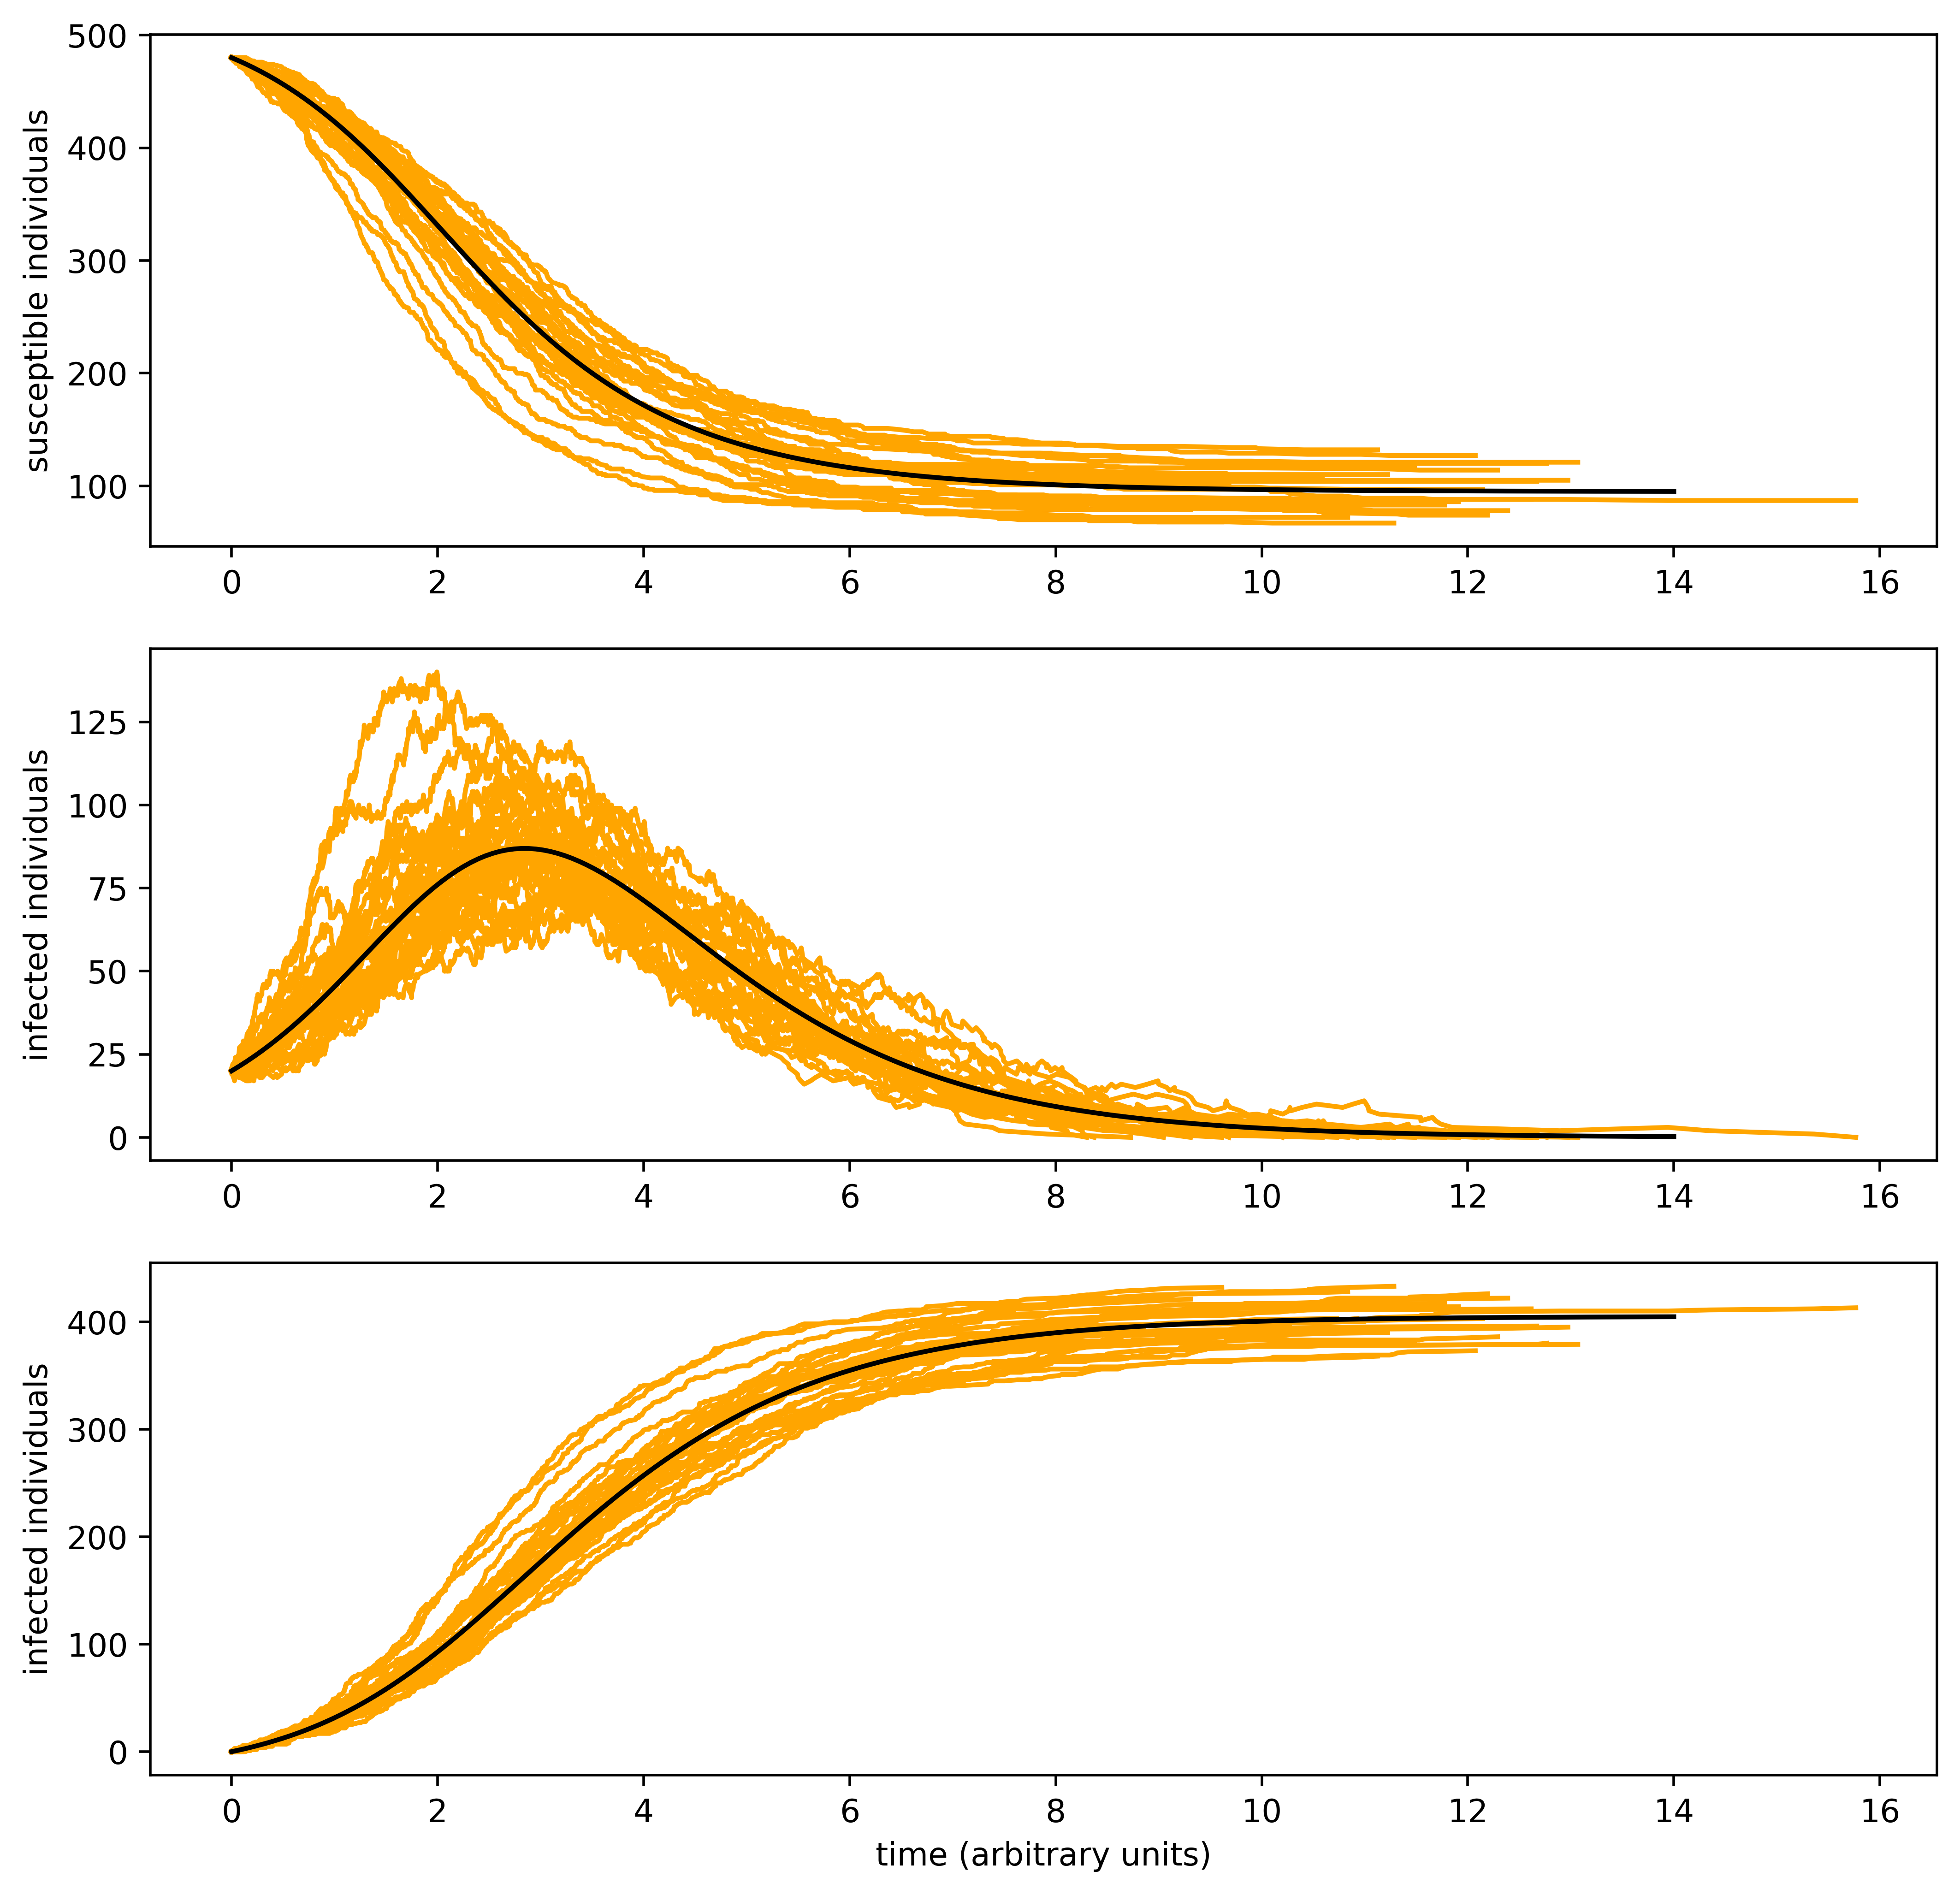

In [71]:
# make a nice, big figure
pyplot.figure(figsize=(10,10), dpi=500)

# make a subplot for susceptible individuals
axes_s = pyplot.subplot(311)
axes_s.set_ylabel("susceptible individuals")

# make a subplot for infected individuals
axes_i = pyplot.subplot(312)
axes_i.set_ylabel("infected individuals")

# make a subplot for recovered individuals
axes_r = pyplot.subplot(313)
axes_r.set_ylabel("infected individuals")
axes_r.set_xlabel("time (arbitrary units)")

# simulate and plot acceptable trajectories
trajectories = 0
for trajectory in epidemic_generator.direct():
    axes_s.plot(trajectory["time"], trajectory["s"], color="orange")
    axes_i.plot(trajectory["time"], trajectory["i"], color="orange")
    axes_r.plot(trajectory["time"], trajectory["r"], color="orange")
    trajectories += 1
    if trajectories == 30:
        break
    
# numerical solution using an ordinary differential equation solver
from scipy.integrate import odeint
from numpy import linspace

# set up parameters as above
t = linspace(0, 14, num=200)
y0 = (480, 20, 0)
alpha = 2.0
beta = 1.0

def differential_SIR(n_SIR, t, alpha, beta):
    dS_dt = -alpha * n_SIR[0] * n_SIR[1] / 500
    dI_dt = ((alpha * n_SIR[0] / 500) - beta) * n_SIR[1]
    dR_dt = beta * n_SIR[1]
    return dS_dt, dI_dt, dR_dt

solution = odeint(differential_SIR, y0, t, args=(alpha, beta))
solution = [[row[i] for row in solution] for i in range(3)]

# plot numerical solution
axes_s.plot(t, solution[0], color="black")
axes_i.plot(t, solution[1], color="black")
axes_r.plot(t, solution[2], color="black")

pyplot.show()

In [ ]:
# testing the first-reaction method
trajectories = 0
for trajectory in epidemic_generator.first_reaction():
    if trajectory["s"][-1] <= 10:
        pyplot.plot(trajectory["time"], trajectory["s"], color="darkorange")
        pyplot.plot(trajectory["time"], trajectory["i"], color="blue")
        pyplot.plot(trajectory["time"], trajectory["r"], color="green")
        trajectories += 1
    else:
        continue
    if trajectories == 10:
        break
pyplot.show()